## Description
I found this dataset on https://www.kaggle.com/datasets/sumanthvrao/daily-climate-time-series-data and thought it would make for good practice with time series data.

The data has the temperature, humidity, wind_speed, and mean pressulre for every day in Delhi from to 2013 to April of 2017. The goal will be to predict 2017 given the previous few years to learn some patterns.

Though the data has a training and test set, I'm actually going to just use the training set file and try to predict into the future. So the "test" file is actually a stand in for real data outside of the training, and the test set I'll use to train the network will be a subset of the "train" file. We'll use a rolling forecast, where each training step will take the last 10 days and predict the next day's temperature.


In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow.keras.regularizers import l2
from statsmodels.tsa.seasonal import seasonal_decompose
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
print(tf.test.gpu_device_name())
print(tf.config.list_physical_devices('GPU'))

/device:GPU:0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2023-08-16 11:34:55.758461: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2023-08-16 11:34:55.758483: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2023-08-16 11:34:55.758487: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2023-08-16 11:34:55.758515: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-08-16 11:34:55.758527: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [2]:
train=pd.read_csv('../data/Delhi_weather/DailyDelhiClimateTrain.csv')
test=pd.read_csv('../data/Delhi_weather/DailyDelhiClimateTest.csv')
start_df = train.drop(train.tail(1).index) #noticed the last entry here is dummy. drop it.
start_df.tail()
test.loc[0,'meanpressure']=train['meanpressure'].iloc[-1]


## Feature engineering
The trends may be capturable with some simple feature engineering. Let's include information from yearly seasons, moving averages, and yesterday's value.

In [3]:
from sklearn.linear_model import LinearRegression


def add_features(init_df):
    init_df['days_since_start'] = (pd.to_datetime(init_df['date'])-pd.to_datetime(init_df['date'][0])).dt.days
    cols = ['days_since_start'] + [col for col in init_df.columns if col != 'days_since_start']
    train = init_df.copy()[cols]
    train.drop('date', axis=1, inplace=True)
    window_size = 3
    for quantity in ['meantemp','humidity','wind_speed','meanpressure']:
        #add a rolling average
        train[quantity+'_rolling'] = train[quantity].rolling(window=window_size).mean()
        # add Fourier features (removing a linear trend)
        linear_model = LinearRegression()
        linear_model.fit(np.array(init_df['days_since_start']).reshape(-1, 1), train[quantity])
        train[quantity+'_trend'] = linear_model.predict(np.array(init_df['days_since_start']).reshape(-1, 1))
        train[quantity+'_detrended']=train[quantity]-train[quantity+'_trend']
    T = 365
    K = 4
    for k in range(1, K + 1):
        train['sin' + str(k)] = np.sin(2 * np.pi * k * train.days_since_start / T)
        train['cos' + str(k)] = np.cos(2 * np.pi * k * train.days_since_start / T)
        
        
        
    #add target (tomorrow's temperature)
    train['target']=train['meantemp'].shift(-1)
    train=train.fillna(method='bfill')
    return train

train=add_features(start_df)
train


,days_since_start,meantemp,humidity,wind_speed,meanpressure,meantemp_rolling,meantemp_trend,meantemp_detrended,humidity_rolling,humidity_trend,...,meanpressure_detrended,sin1,cos1,sin2,cos2,sin3,cos3,sin4,cos4,target
0,0,10.000000,84.500000,0.000000,1015.666667,8.188889,23.813416,-13.813416,87.833333,62.279249,...,8.872009,0.000000e+00,1.000000,0.000000e+00,1.000000,0.000000e+00,1.000000,0.000000e+00,1.000000,7.400000
1,1,7.400000,92.000000,2.980000,1017.800000,8.188889,23.815734,-16.415734,87.833333,62.277147,...,10.999443,1.721336e-02,0.999852,3.442161e-02,0.999407,5.161967e-02,0.998667,6.880243e-02,0.997630,7.166667
2,2,7.166667,87.000000,4.633333,1018.666667,8.188889,23.818053,-16.651386,87.833333,62.275045,...,11.860210,3.442161e-02,0.999407,6.880243e-02,0.997630,1.031017e-01,0.994671,1.372788e-01,0.990532,8.666667
3,3,8.666667,71.333333,1.233333,1017.166667,7.744444,23.820372,-15.153705,83.444444,62.272943,...,10.354311,5.161967e-02,0.998667,1.031017e-01,0.994671,1.543088e-01,0.988023,2.051045e-01,0.978740,6.000000
4,4,6.000000,86.833333,3.700000,1016.500000,7.277778,23.822691,-17.822691,81.722222,62.270841,...,9.681745,6.880243e-02,0.997630,1.372788e-01,0.990532,2.051045e-01,0.978740,2.719582e-01,0.962309,7.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456,1456,16.850000,67.550000,8.335000,1017.200000,15.997619,27.189563,-10.339563,78.902381,59.218861,...,1.815861,-6.880243e-02,0.997630,-1.372788e-01,0.990532,-2.051045e-01,0.978740,-2.719582e-01,0.962309,17.217391
1457,1457,17.217391,68.043478,3.547826,1015.565217,17.070083,27.191882,-9.974490,70.150207,59.216760,...,0.175179,-5.161967e-02,0.998667,-1.031017e-01,0.994671,-1.543088e-01,0.988023,-2.051045e-01,0.978740,15.238095
1458,1458,15.238095,87.857143,6.000000,1016.904762,16.435162,27.194200,-11.956105,74.483540,59.214658,...,1.508824,-3.442161e-02,0.999407,-6.880243e-02,0.997630,-1.031017e-01,0.994671,-1.372788e-01,0.990532,14.095238
1459,1459,14.095238,89.666667,6.266667,1017.904762,15.516908,27.196519,-13.101281,81.855763,59.212556,...,2.502925,-1.721336e-02,0.999852,-3.442161e-02,0.999407,-5.161967e-02,0.998667,-6.880243e-02,0.997630,15.052632


### Create a model



In [4]:
#we will train on 10 days, then predict the 11th

# Separate features and target
features = train.iloc[:, :-1]
target = train.iloc[:, -1]

# Normalize the features using StandardScaler
scaler = MinMaxScaler()
features_scaled = scaler.fit_transform(features)

target_scaler = MinMaxScaler()
targets_scaled = target_scaler.fit_transform(target.values.reshape(-1, 1))

# Create sequences for LSTM
time_steps = 10
X, y = [], []

for i in range(len(features_scaled) - time_steps):
    X.append(features_scaled[i:i+time_steps])
    y.append(targets_scaled[i-1+time_steps])
    
X = np.array(X)
n_features=X.shape[2]
y = np.array(y)
print(np.shape(X))
print(np.shape(y))


(1451, 10, 25)
(1451, 1)


### Training

In [5]:

model = Sequential([
    Dense(64,input_shape=(X.shape[1], X.shape[2])), #I find these layers help map relationships between features
    Dense(64,input_shape=(X.shape[1], X.shape[2])), 
    Dropout(0.2),
    LSTM(64, return_sequences=True),#,kernel_regularizer=l2(0.01)), # I considered regularization but used dropout instead
    Dropout(0.2),
    LSTM(32,return_sequences=True),
    Dropout(0.2),
    LSTM(16),
    Dense(1) # Output layer with one unit since we are predicting a single value
])

model.compile(optimizer='adam', loss='mse')
history=model.fit(X, y, epochs=25, verbose=1)


2023-08-16 11:34:55.871711: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-08-16 11:34:55.871730: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Epoch 1/25


2023-08-16 11:34:57.411193: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-08-16 11:34:57.652384: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-08-16 11:34:57.698201: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-08-16 11:34:57.739501: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-08-16 11:34:57.811364: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


 4/46 [=>............................] - ETA: 0s - loss: 0.1526  

2023-08-16 11:34:57.894748: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-08-16 11:34:57.958273: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


46/46 [==============================] - 3s 19ms/step - loss: 0.0307
Epoch 2/25
46/46 [==============================] - 1s 16ms/step - loss: 0.0055
Epoch 3/25
46/46 [==============================] - 1s 16ms/step - loss: 0.0049
Epoch 4/25
46/46 [==============================] - 1s 16ms/step - loss: 0.0048
Epoch 5/25
46/46 [==============================] - 1s 17ms/step - loss: 0.0049
Epoch 6/25
46/46 [==============================] - 1s 19ms/step - loss: 0.0043
Epoch 7/25
46/46 [==============================] - 1s 17ms/step - loss: 0.0042
Epoch 8/25
46/46 [==============================] - 1s 16ms/step - loss: 0.0041
Epoch 9/25
46/46 [==============================] - 1s 17ms/step - loss: 0.0041
Epoch 10/25
46/46 [==============================] - 1s 16ms/step - loss: 0.0041
Epoch 11/25
46/46 [==============================] - 1s 16ms/step - loss: 0.0039
Epoch 12/25
46/46 [==============================] - 1s 16ms/step - loss: 0.0037
Epoch 13/25
46/46 [=============================

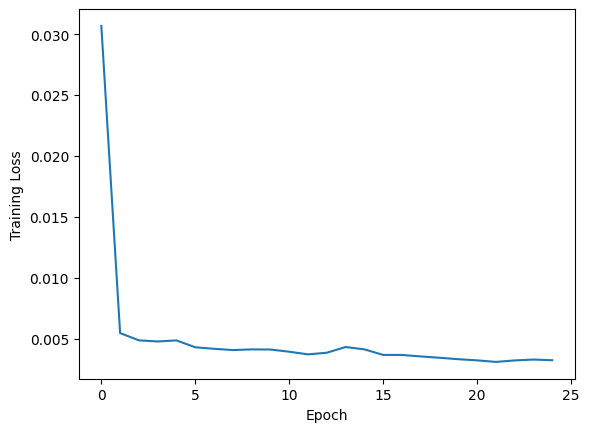

In [6]:
plt.plot(history.history['loss'])
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.show()

In [7]:
#function that takes test data, evaluates features of last 10 days, predicts next day

#the tricky part is that the first day of the test requires the previous days from the training. Solve this by appending these days
last_10_days=start_df.tail(13)
evaluate_df = pd.concat([last_10_days, test], ignore_index=True)
#evaluate same features:
def add_features_test(init_df):
    init_df['days_since_start'] = (pd.to_datetime(init_df['date'])-pd.to_datetime(start_df['date'][0])).dt.days
    cols = ['days_since_start'] + [col for col in init_df.columns if col != 'days_since_start']
    test = init_df.copy()[cols]
    test.drop('date', axis=1, inplace=True)
    window_size = 3
    for quantity in ['meantemp','humidity','wind_speed','meanpressure']:
        #add a rolling average
        test[quantity+'_rolling'] = test[quantity].rolling(window=window_size).mean()
        # now when adding Fourier features, need to remove linear trend fit on TRAINING data
        linear_model = LinearRegression()
        linear_model.fit(np.array(train['days_since_start']).reshape(-1, 1), train[quantity])
        test[quantity+'_trend'] = linear_model.predict(np.array(init_df['days_since_start']).reshape(-1, 1))
        test[quantity+'_detrended']=test[quantity]-test[quantity+'_trend']
    T = 365
    K = 4
    for k in range(1, K + 1):
        test['sin' + str(k)] = np.sin(2 * np.pi * k * test.days_since_start / T)
        test['cos' + str(k)] = np.cos(2 * np.pi * k * test.days_since_start / T)
    test=test.fillna(method='bfill')
    return test
evaluate_df=add_features_test(evaluate_df)
test[:20]


,date,meantemp,humidity,wind_speed,meanpressure
0,2017-01-01,15.913043,85.869565,2.743478,1016.000000
1,2017-01-02,18.500000,77.222222,2.894444,1018.277778
2,2017-01-03,17.111111,81.888889,4.016667,1018.333333
3,2017-01-04,18.700000,70.050000,4.545000,1015.700000
4,2017-01-05,18.388889,74.944444,3.300000,1014.333333
5,2017-01-06,19.318182,79.318182,8.681818,1011.772727
6,2017-01-07,14.708333,95.833333,10.041667,1011.375000
7,2017-01-08,15.684211,83.526316,1.950000,1015.550000
8,2017-01-09,14.571429,80.809524,6.542857,1015.952381
9,2017-01-10,12.111111,71.944444,9.361111,1016.888889


2023-08-16 11:35:17.438165: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-08-16 11:35:17.536237: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-08-16 11:35:17.574071: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-08-16 11:35:17.607329: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


0.011237901705256627


Text(0.5, 1.0, 'Predicted temperature given the last 10 days')

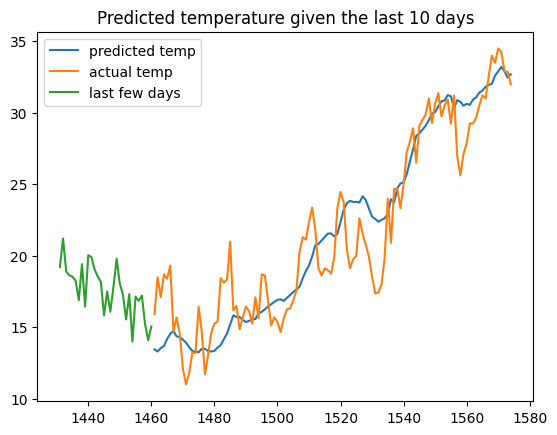

In [8]:
def predict_next_day(df):
    X_test=scaler.transform(df)
    X_test = np.array(X_test).reshape(-1, 10, n_features)
    y=model.predict(X_test,verbose=0)
    return target_scaler.inverse_transform(y)
prediction=[]
actual=[]
predicted_day=[]
for index_to_check in range(13,len(evaluate_df)):
    prediction.append(predict_next_day(evaluate_df.iloc[index_to_check-10:index_to_check]).squeeze())
    actual.append(evaluate_df['meantemp'].iloc[index_to_check])
    predicted_day.append(evaluate_df['days_since_start'].iloc[index_to_check])
    
plt.plot(predicted_day,prediction,label='predicted temp')
plt.plot(predicted_day,actual,label='actual temp')
plt.plot(train['days_since_start'].iloc[-30:],train['meantemp'].iloc[-30:],label='last few days')
print(np.mean(np.array(prediction)-np.array(actual))**2)

plt.legend()
plt.title('Predicted temperature given the last 10 days')

## Growing Errors into the Future

Just out of curiosity, what if we use the prediction to make a prediction, and so on, propagating errors into the future


0.06408377463222309


Text(0.5, 1.0, 'Predicted temperature given 10 days at the end of last year')

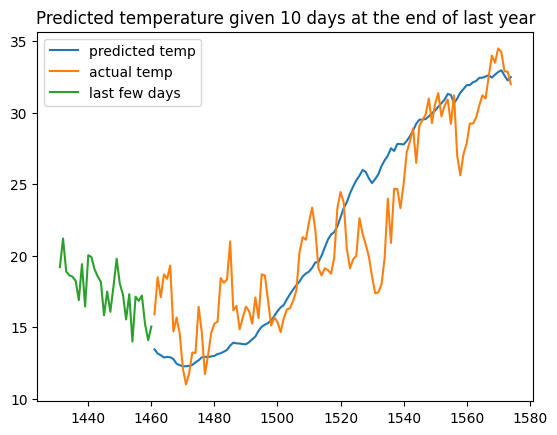

In [9]:
future_df=evaluate_df.copy()
prediction=[]
for index_to_check in range(13,len(future_df)):
    prediction.append(predict_next_day(future_df.iloc[index_to_check-10:index_to_check]).squeeze())
    #update features with values calculated from prediction
    future_df.loc[index_to_check, 'meantemp']=prediction[-1]
    future_df.loc[index_to_check, 'meantemp_rolling']=np.mean(future_df.meantemp.iloc[index_to_check-2:index_to_check+1])
    future_df.loc[index_to_check, 'meantemp_detrended']=future_df['meantemp'].iloc[index_to_check]-future_df['meantemp_trend'].iloc[index_to_check]
print(np.mean(np.array(prediction)-np.array(actual))**2)
plt.plot(predicted_day,prediction,label='predicted temp')
plt.plot(predicted_day,actual,label='actual temp')
plt.plot(train['days_since_start'].iloc[-30:],train['meantemp'].iloc[-30:],label='last few days')
plt.legend()
plt.title('Predicted temperature given 10 days at the end of last year')

Not great, but it doesn't look as bad as I expected. It still has information from the other features e.g. humidity, wind, pressure. The trend looks much simpler so it's probably relying mostly on its linear and Fourier temperature features.